In [95]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, average_precision_score, confusion_matrix, classification_report
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =============================================================================
# Project: Next-year financial distress prediction (firm-year panel)
# Data Science Lifecycle focus in this cell:
#   - Setup & configuration (temporal split conventions, leakage control parameters)
#   - Panel integrity (types, deduplication, stable firm identifier)
#   - Define label_year used consistently for splitting and target alignment
# =============================================================================

# ----------------------------
# Configuration (split & preprocessing parameters)
# ----------------------------
FILE_NAME = "data.csv"

TRAIN_CUTOFF_LABEL_YEAR = 2022   # label_year <= cutoff → train/val pool; after cutoff → test
VAL_YEARS = 1                    # last N years within the pool are validation
N_SPLITS_TIME_CV = 4             # rolling time-based folds for sanity checks

WINSOR_LOWER_Q = 0.01            # winsorization lower quantile (train-only)
WINSOR_UPPER_Q = 0.99            # winsorization upper quantile (train-only)

REQUIRED_KEYS = ["gvkey", "fyear"]


# ----------------------------
# Utilities (robust numeric ops for ratios)
# ----------------------------

def to_float_numpy(x) -> np.ndarray:
    """Convert series/array-like to float numpy array, coercing non-numeric to NaN."""
    s = pd.to_numeric(x, errors="coerce")
    return s.to_numpy(dtype=float) if hasattr(s, "to_numpy") else np.asarray(s, dtype=float)
def safe_divide(a, b) -> np.ndarray:
    """Elementwise divide a/b with NaN when division is invalid (0 or non-finite)."""
    a = to_float_numpy(a)
    b = to_float_numpy(b)
    out = np.full_like(a, np.nan, dtype=float)
    np.divide(a, b, out=out, where=(b != 0) & np.isfinite(a) & np.isfinite(b))
    return out

def rolling_year_folds(
    df_in: pd.DataFrame, year_col: str = "label_year", n_splits: int = 4, min_train_years: int = 3
) -> list[tuple[np.ndarray, np.ndarray, np.ndarray, int]]:
    """
    Create expanding-window time folds:
      train years: first (min_train_years + k) years
      val year:    next year
    Returns: list of (train_idx, val_idx, train_years, val_year)
    """
    years_sorted = np.sort(df_in[year_col].dropna().unique())
    if len(years_sorted) <= min_train_years:
        return []
    n_splits = min(n_splits, len(years_sorted) - min_train_years)

    folds_out = []
    for k in range(n_splits):
        train_years = years_sorted[: min_train_years + k]
        val_year = int(years_sorted[min_train_years + k])

        train_idx = df_in.index[df_in[year_col].isin(train_years)].to_numpy()
        val_idx = df_in.index[df_in[year_col] == val_year].to_numpy()
        folds_out.append((train_idx, val_idx, train_years, val_year))

    return folds_out


# =============================================================================
# 1) Data acquisition & panel hygiene
# =============================================================================
df = pd.read_csv(FILE_NAME, low_memory=False)

# Convert datadate if present
if "datadate" in df.columns:
    df["datadate"] = pd.to_datetime(df["datadate"], errors="coerce")

# Create stable firm id + de-duplicate firm-year (keep last record)
df["firm_id"] = df["gvkey"]
df = (
    df.sort_values(["firm_id", "fyear"])
      .drop_duplicates(subset=["firm_id", "fyear"], keep="last")
      .reset_index(drop=True)
)

# Label year: predict distress in the next fiscal year
df["label_year"] = df["fyear"] + 1

# =============================================================================
# 2) Split scaffolding (define train/val pool years via label_year)
# =============================================================================
pool_mask = df["label_year"] <= TRAIN_CUTOFF_LABEL_YEAR
pool_years = np.sort(df.loc[pool_mask, "label_year"].dropna().unique())
val_years = pool_years[-VAL_YEARS:] if len(pool_years) else np.array([], dtype=int)

# This mask is ONLY used for imputations (train-only information)
train_mask_for_imputation = pool_mask & (~df["label_year"].isin(val_years))


In [96]:
# =============================================================================
# Data Cleaning & Missing-Data Handling (leakage-aware)
# Purpose:
#   - Quantify missingness and distribution properties before intervention
#   - Preserve informative missingness via miss_* indicators
#   - Impute financial statement inputs using TRAIN-only information:
#       (1) within-firm past values (ffill) where economically sensible
#       (2) peer medians by year on size-scaled ratios
#   - Re-run EDA after imputation to audit how strongly imputations alter the data
# =============================================================================

RAW_INPUTS_FOR_FE = [
    "aco","act","ao","aoloch","ap","apalch","aqc","at","caps","capx","ceq","che","chech","csho","cstk","cstke",
    "datadate","dlc","dlcch","dltis","dltr","dltt","do","dp","dpc","dv","dvc","dvp","dvt","esubc","exre",
    "fiao","fincf","fopo","fyear","gvkey","ib","ibadj","ibc","intan","invch","invt","ismod","ivaco","ivaeq",
    "ivao","ivch","ivncf","ivstch","lco","lct","lt","mibt","mkvalt","niadj","nopi","oancf","oibdp","ppent",
    "prcc_c","prcc_f","prstkc","pstk","pstkn","pstkr","re","recch","rect","seq","siv","spi","sppe","sppiv",
    "sstk","tstk","txach","txbcof","txdc","txditc","txp","txt","xi","xido","xidoc","xint",
    # optional identifiers present in many extracts:
    "conm","consol","datafmt","indfmt",
]
raw = [c for c in RAW_INPUTS_FOR_FE if c in df.columns]

# ---------------------------------------------------------------------------
# 3.0 Ensure keys exist + types
# ---------------------------------------------------------------------------
# firm_id used for panel operations
if "firm_id" not in df.columns:
    if "gvkey" in df.columns:
        df["firm_id"] = df["gvkey"]
    else:
        raise ValueError("Need either firm_id or gvkey in df to run panel imputations.")

# fyear numeric
if "fyear" in df.columns:
    df["fyear"] = pd.to_numeric(df["fyear"], errors="coerce")


# ---------------------------------------------------------------------------
# 3.1 Drop rows with missing critical identifiers (do not impute these)
# ---------------------------------------------------------------------------
NON_IMPUTE_DROP = [c for c in ["gvkey", "datadate", "fyear", "conm", "datafmt", "indfmt", "consol"] if c in df.columns]
if NON_IMPUTE_DROP:
    before_n = df.shape[0]
    df = df.dropna(subset=NON_IMPUTE_DROP).copy()
    after_n = df.shape[0]
    if after_n < before_n:
        print(f"[INFO] Dropped {before_n - after_n:,} rows due to missing non-imputable ID/meta fields: {NON_IMPUTE_DROP}")

# Rebuild raw after potential drop
raw = [c for c in RAW_INPUTS_FOR_FE if c in df.columns]

# ---------------------------------------------------------------------------
# 3.2 EDA BEFORE imputation (missingness + distribution snapshot)
# ---------------------------------------------------------------------------
df_raw_pre = df[raw].copy(deep=True)

pre_miss = pd.DataFrame(
    {
        "col": raw,
        "n": [int(df_raw_pre[c].shape[0]) for c in raw],
        "n_na_pre": [int(df_raw_pre[c].isna().sum()) for c in raw],
        "pct_na_pre": [float(df_raw_pre[c].isna().mean() * 100.0) for c in raw],
        "train_n": [int(train_mask_for_imputation.sum()) for _ in raw],
        "train_pct_na_pre": [
            float(df_raw_pre.loc[train_mask_for_imputation, c].isna().mean() * 100.0) for c in raw
        ],
    }
).sort_values("pct_na_pre", ascending=False)

print("\n=== EDA (BEFORE imputation): Missingness on raw inputs ===")
print(pre_miss.round(4).head(50))

# Numeric distribution summary (exclude obvious non-numeric)
if raw:
    x_pre = df_raw_pre[raw].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
    q_pre = x_pre.quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T
    pre_dist = pd.DataFrame(
        {
            "n_nonmiss_pre": x_pre.notna().sum(),
            "mean_pre": x_pre.mean(),
            "std_pre": x_pre.std(ddof=0),
            "min_pre": x_pre.min(),
            "p01_pre": q_pre[0.01],
            "p05_pre": q_pre[0.05],
            "p25_pre": q_pre[0.25],
            "p50_pre": q_pre[0.50],
            "p75_pre": q_pre[0.75],
            "p95_pre": q_pre[0.95],
            "p99_pre": q_pre[0.99],
            "max_pre": x_pre.max(),
        }
    )
    print("\n=== EDA (BEFORE imputation): Distribution summary (raw inputs) ===")
    print(pre_dist.round(4).sort_values("n_nonmiss_pre", ascending=True).head(50))

# ---------------------------------------------------------------------------
# 3.3 Missingness flags (ALWAYS create before imputations)
# ---------------------------------------------------------------------------
for c in raw:
    df[f"miss_{c}"] = df[c].isna().astype("int8")

# ---------------------------------------------------------------------------
# 3.4 Grouping key for peer-based imputations
# ---------------------------------------------------------------------------
group_cols = ["fyear"]

# 3.5 Step 1: Construct / reconcile FIRST (no leakage: uses contemporaneous or lag only)
# ---------------------------------------------------------------------------
df = df.sort_values(["firm_id", "fyear"]).copy()

# 3.5.1 mkvalt construction from prcc_f * csho (if mkvalt missing)
if all(c in df.columns for c in ["mkvalt", "prcc_f", "csho"]):
    mkvalt_miss = df["mkvalt"].isna()
    mkvalt_calc = pd.to_numeric(df["prcc_f"], errors="coerce") * pd.to_numeric(df["csho"], errors="coerce")
    df.loc[mkvalt_miss & mkvalt_calc.notna(), "mkvalt"] = mkvalt_calc.loc[mkvalt_miss & mkvalt_calc.notna()]

# 3.5.2 Reconstruct change variables from level differences (fill only if change var is missing)
def _fill_change_from_levels(change_col, level_col):
    if change_col in df.columns and level_col in df.columns:
        miss = df[change_col].isna()
        lvl = pd.to_numeric(df[level_col], errors="coerce")
        lag_lvl = df.groupby("firm_id")[level_col].shift(1)
        lag_lvl = pd.to_numeric(lag_lvl, errors="coerce")
        recon = lvl - lag_lvl
        df.loc[miss & recon.notna(), change_col] = recon.loc[miss & recon.notna()]

_fill_change_from_levels("dlcch", "dlc")
_fill_change_from_levels("recch", "rect")
_fill_change_from_levels("invch", "invt")
_fill_change_from_levels("chech", "che")

# ---------------------------------------------------------------------------
# 3.6 Step 3: Stocks — firm-history (ffill) -> group median of ratio (x/at)
# ---------------------------------------------------------------------------
STOCKS = [c for c in [
    "aco","act","ao","ap","at","caps","ceq","che","csho","cstk","dlc","dltt","intan","invt","lco","lct","lt",
    "mibt","ppent","pstk","pstkn","pstkr","re","rect","seq","tstk","ivaeq","mkvalt"
] if c in df.columns]

# firm-history forward fill within each firm (uses only past observations)
if STOCKS:
    df[STOCKS] = df.groupby("firm_id")[STOCKS].ffill()

# ratio median impute remaining missing stocks (fit on training only)
NONNEG_STOCKS = set([c for c in STOCKS if c in {"aco","act","ao","ap","at","caps","ceq","che","csho","cstk","dlc","dltt",
                                               "intan","invt","lco","lct","lt","mibt","mkvalt","ppent","pstk","pstkn","pstkr",
                                               "rect","seq","tstk","ivaeq"}])

def _fit_ratio_medians(train_df, col, size_col="at"):
    # returns (overall_ratio_median, series indexed by group tuple)
    s = pd.to_numeric(train_df[col], errors="coerce")
    size = pd.to_numeric(train_df[size_col], errors="coerce") if size_col in train_df.columns else None
    if size is None:
        # fallback: level median by groups
        grp_med = train_df.groupby(group_cols)[col].median()
        overall = float(s.median()) if s.notna().any() else 0.0
        return ("level", overall, grp_med)

    valid = s.notna() & size.notna() & (size > 0)
    if valid.sum() == 0:
        grp_med = train_df.groupby(group_cols)[col].median()
        overall = float(s.median()) if s.notna().any() else 0.0
        return ("level", overall, grp_med)

    ratio = (s[valid] / size[valid]).replace([np.inf, -np.inf], np.nan).dropna()
    overall = float(ratio.median()) if ratio.notna().any() else 0.0
    tmp = train_df.loc[valid, group_cols].copy()
    tmp["_ratio_"] = ratio.values
    grp_med = tmp.groupby(group_cols)["_ratio_"].median()
    return ("ratio", overall, grp_med)

def _apply_ratio_medians(df_all, col, fit_obj, size_col="at", nonneg=False):
    kind, overall, grp_med = fit_obj
    miss = df_all[col].isna()
    if not miss.any():
        return

    if kind == "ratio" and size_col in df_all.columns:
        size = pd.to_numeric(df_all.loc[miss, size_col], errors="coerce")
        # map group median ratio
        g = df_all.loc[miss, group_cols]
        mapped = pd.Series([np.nan] * miss.sum(), index=df_all.index[miss], dtype="float64")
        # build tuple key if multi-col grouping
        if len(group_cols) == 1:
            mapped = g[group_cols[0]].map(grp_med)
        else:
            keys = list(map(tuple, g[group_cols].to_numpy()))
            mapped = pd.Series(keys, index=g.index).map(grp_med)

        r = pd.to_numeric(mapped, errors="coerce").fillna(overall)
        fill = r * size
        # if size missing/<=0, fallback to level median within groups
        fill = fill.where(size.notna() & (size > 0), np.nan)
        df_all.loc[miss & fill.notna(), col] = fill.loc[miss & fill.notna()].to_numpy()

    # fallback: level median by group (still fit on training)
    # (use training group median of levels if ratio path didn't fill everything)
    miss2 = df_all[col].isna()
    if miss2.any():
        tr = df_all.loc[train_mask_for_imputation, [*group_cols, col]].copy()
        tr[col] = pd.to_numeric(tr[col], errors="coerce")
        lvl_overall = float(tr[col].median()) if tr[col].notna().any() else 0.0
        lvl_grp = tr.groupby(group_cols)[col].median()

        g2 = df_all.loc[miss2, group_cols]
        if len(group_cols) == 1:
            mapped2 = g2[group_cols[0]].map(lvl_grp)
        else:
            keys2 = list(map(tuple, g2[group_cols].to_numpy()))
            mapped2 = pd.Series(keys2, index=g2.index).map(lvl_grp)

        fill2 = pd.to_numeric(mapped2, errors="coerce").fillna(lvl_overall)
        if nonneg:
            fill2 = fill2.clip(lower=0.0)
        df_all.loc[miss2, col] = fill2.to_numpy()

# Fit on training
tr_all = df.loc[train_mask_for_imputation].copy()
ratio_fits = {}
for c in STOCKS:
    ratio_fits[c] = _fit_ratio_medians(tr_all, c, size_col="at")

# Apply to full df
for c in STOCKS:
    _apply_ratio_medians(df, c, ratio_fits[c], size_col="at", nonneg=(c in NONNEG_STOCKS))

# ---------------------------------------------------------------------------
# 3.7 Step 4: Flows / income variables — ratio-median imputation (leakage-aware)
# ---------------------------------------------------------------------------
# Practical adjustments for this project:
#   (i)  Interest expense (xint) scales more naturally with debt than with assets.
#        => prefer imputing xint via (xint / total_debt) when debt is available.
#   (ii) Tax components used in the FFO proxy (txt, txdc, txach) should not block feature construction.
#        => set missing components to 0.0 (retain miss_* flags as indicators).
#   (iii) Ratio×size imputations can explode for very large firms.
#        => clip only-imputed values to a robust training-observed quantile band.

FLOWS = [c for c in [
    "ib","ibadj","ibc","niadj","nopi","oibdp","dp","txt","oancf","fincf","ivncf","xint","esubc"
] if c in df.columns]

# --- Debt-aware base for xint (after stock imputations have populated dlc/dltt) ---
if "xint" in df.columns and all(c in df.columns for c in ["dlc", "dltt"]):
    df["_td_for_xint"] = (
        pd.to_numeric(df["dlc"], errors="coerce").fillna(0.0)
        + pd.to_numeric(df["dltt"], errors="coerce").fillna(0.0)
    )
else:
    df["_td_for_xint"] = np.nan

# Debt-aware rule: if total debt == 0, interest expense is set to 0 (keep miss flag already created)
if "xint" in df.columns and "_td_for_xint" in df.columns:
    xint_miss = df["xint"].isna()
    df.loc[xint_miss & (pd.to_numeric(df["_td_for_xint"], errors="coerce").fillna(0.0) <= 0), "xint"] = 0.0

# Fit ratio medians on training and apply (xint uses debt base when possible; otherwise assets base)
flow_fits = {}
for c in FLOWS:
    size_base = "_td_for_xint" if (c == "xint" and "_td_for_xint" in df.columns) else "at"
    flow_fits[c] = _fit_ratio_medians(tr_all, c, size_col=size_base)

for c in FLOWS:
    size_base = "_td_for_xint" if (c == "xint" and "_td_for_xint" in df.columns) else "at"
    # flows can be negative; do not clip to non-negative
    _apply_ratio_medians(df, c, flow_fits[c], size_col=size_base, nonneg=False)

# --- Practical fill: tax components used in FFO proxy ---
for c in ["txt", "txdc", "txach"]:
    if c in df.columns:
        df.loc[df[c].isna(), c] = 0.0

# --- Practical guardrail: cap only-imputed values to training-observed quantiles ---
def _cap_imputed_to_train_quantiles(
    df_all: pd.DataFrame,
    col: str,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    nonneg: bool = False,
) -> None:
    flag = f"miss_{col}"
    if col not in df_all.columns or flag not in df_all.columns:
        return

    miss_mask = df_all[flag].astype(bool)
    if not miss_mask.any():
        return

    # Prefer bounds from observed (not originally missing) values in the training split
    obs = pd.to_numeric(df_all.loc[train_mask_for_imputation & (~miss_mask), col], errors="coerce")
    if obs.notna().sum() < 200:
        obs = pd.to_numeric(df_all.loc[train_mask_for_imputation, col], errors="coerce")

    if obs.notna().sum() == 0:
        return

    lo = float(obs.quantile(lower_q))
    hi = float(obs.quantile(upper_q))

    if nonneg:
        lo = max(0.0, lo) if np.isfinite(lo) else 0.0

    s = pd.to_numeric(df_all.loc[miss_mask, col], errors="coerce")
    df_all.loc[miss_mask, col] = s.clip(lo, hi).to_numpy()

# Apply capping to the variables that are later used (directly or indirectly) in engineered ratios
CAP_COLS = sorted(set(STOCKS + FLOWS + ["dlcch", "apalch", "recch", "invch", "chech"]) & set(df.columns))
for c in CAP_COLS:
    _cap_imputed_to_train_quantiles(df, c, lower_q=0.01, upper_q=0.99, nonneg=(c in NONNEG_STOCKS))


# 3.8 EDA AFTER imputation (missingness reduction + distribution deltas)
# ---------------------------------------------------------------------------
df_raw_post = df[raw].copy(deep=True)

post_miss = pd.DataFrame(
    {
        "col": raw,
        "n_na_post": [int(df_raw_post[c].isna().sum()) for c in raw],
        "pct_na_post": [float(df_raw_post[c].isna().mean() * 100.0) for c in raw],
        "train_pct_na_post": [
            float(df_raw_post.loc[train_mask_for_imputation, c].isna().mean() * 100.0) for c in raw
        ],
    }
)

changes = pre_miss.merge(post_miss, on="col", how="left")
changes["n_imputed"] = changes["n_na_pre"] - changes["n_na_post"]
changes["pct_points_na_reduction"] = changes["pct_na_pre"] - changes["pct_na_post"]

x_post = df_raw_post[raw].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)
q_post = x_post.quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T
post_dist = pd.DataFrame(
    {
        "n_nonmiss_post": x_post.notna().sum(),
        "mean_post": x_post.mean(),
        "std_post": x_post.std(ddof=0),
        "min_post": x_post.min(),
        "p01_post": q_post[0.01],
        "p05_post": q_post[0.05],
        "p25_post": q_post[0.25],
        "p50_post": q_post[0.50],
        "p75_post": q_post[0.75],
        "p95_post": q_post[0.95],
        "p99_post": q_post[0.99],
        "max_post": x_post.max(),
    }
)

pre_dist_key = pre_dist[["n_nonmiss_pre","mean_pre","std_pre","p01_pre","p50_pre","p99_pre"]].copy() if raw else pd.DataFrame()
post_dist_key = post_dist[["n_nonmiss_post","mean_post","std_post","p01_post","p50_post","p99_post"]].copy() if raw else pd.DataFrame()

dist_delta = pre_dist_key.join(post_dist_key, how="outer")
dist_delta["delta_mean"] = dist_delta["mean_post"] - dist_delta["mean_pre"]
dist_delta["delta_std"]  = dist_delta["std_post"]  - dist_delta["std_pre"]
dist_delta["delta_p50"]  = dist_delta["p50_post"]  - dist_delta["p50_pre"]

# Imputed-only diagnostics
rows = []
for c in raw:
    pre_na_mask = df_raw_pre[c].isna()
    n_imp = int(pre_na_mask.sum())
    if n_imp == 0:
        rows.append((c, 0, np.nan, np.nan, np.nan, np.nan, np.nan))
        continue

    imp_vals = pd.to_numeric(df_raw_post.loc[pre_na_mask, c], errors="coerce").replace([np.inf, -np.inf], np.nan)
    obs_vals = pd.to_numeric(df_raw_pre.loc[~pre_na_mask, c], errors="coerce").replace([np.inf, -np.inf], np.nan)

    rows.append(
        (
            c,
            n_imp,
            float(imp_vals.mean()) if imp_vals.notna().any() else np.nan,
            float(imp_vals.median()) if imp_vals.notna().any() else np.nan,
            float(imp_vals.std(ddof=0)) if imp_vals.notna().any() else np.nan,
            float(obs_vals.mean()) if obs_vals.notna().any() else np.nan,
            float(obs_vals.median()) if obs_vals.notna().any() else np.nan,
        )
    )

imputed_only = pd.DataFrame(
    rows,
    columns=["col","n_imputed","imputed_mean","imputed_median","imputed_std","observed_mean_pre","observed_median_pre"],
).set_index("col")

print("\n=== EDA (AFTER imputation): Missingness on raw inputs + change ===")
cols_show = [
    "col", "n", "n_na_pre", "pct_na_pre", "n_na_post", "pct_na_post",
    "n_imputed", "pct_points_na_reduction", "train_pct_na_pre", "train_pct_na_post",
]
print(
    changes[cols_show]
    .sort_values(["n_imputed","pct_points_na_reduction"], ascending=[False, False])
    .round(4)
    .head(50)
)

print("\n=== Change analysis: Distribution deltas (post - pre) on raw inputs ===")
print(
    dist_delta[["n_nonmiss_pre","n_nonmiss_post","delta_mean","delta_std","delta_p50"]]
    .sort_values("delta_mean", key=lambda s: s.abs(), ascending=False)
    .round(6)
    .head(50)
)

print("\n=== Change analysis: Imputed-only vs observed (pre) summary ===")
print(
    imputed_only.assign(
        mean_gap_imputed_minus_observed=lambda d: d["imputed_mean"] - d["observed_mean_pre"],
        median_gap_imputed_minus_observed=lambda d: d["imputed_median"] - d["observed_median_pre"],
    )
    .sort_values("n_imputed", ascending=False)
    .round(6)
    .head(50)
)


=== EDA (BEFORE imputation): Missingness on raw inputs ===
       col      n  n_na_pre  pct_na_pre  train_n  train_pct_na_pre
18   dlcch  75005     33143     44.1877    48458           42.9630
5   apalch  75005     30371     40.4920    48458           39.0214
75   txach  75005     22791     30.3860    48458           29.2501
48  ivstch  75005     19194     25.5903    48458           23.0282
66   recch  75005     12589     16.7842    48458           16.5938
53  mkvalt  75005     12350     16.4656    48458           17.0189
71    sppe  75005     12239     16.3176    48458           16.4307
1      act  75005     10721     14.2937    48458           14.6581
50     lct  75005     10695     14.2590    48458           14.5982
84    xint  75005     10536     14.0471    48458           13.9234
78  txditc  75005      9069     12.0912    48458           12.2044
79     txp  75005      7942     10.5886    48458           10.6917
29   esubc  75005      6798      9.0634    48458            8.8964
49

In [97]:

# =============================================================================
# Feature Engineering & Target Construction
#   - Build leverage / coverage / cash-flow-to-debt ratios commonly used in credit analysis
#   - Define a 'highly leveraged' distress proxy from multiple ratio-based conditions
#   - Create the supervised-learning target: next-year distress within the same firm
# =============================================================================
dlc = pd.to_numeric(df.get("dlc", np.nan), errors="coerce")
dltt = pd.to_numeric(df.get("dltt", np.nan), errors="coerce")
df["total_debt"] = pd.concat([dlc, dltt], axis=1).sum(axis=1, min_count=1)

seq = pd.to_numeric(df.get("seq", np.nan), errors="coerce")
mibt = pd.to_numeric(df.get("mibt", 0.0), errors="coerce")
df["equity_plus_mi_sp"] = seq + mibt
df["total_capital_sp"] = df["total_debt"] + df["equity_plus_mi_sp"]
df["sp_debt_to_capital"] = safe_divide(df["total_debt"], df["total_capital_sp"])

oibdp = pd.to_numeric(df.get("oibdp", np.nan), errors="coerce")
xint = pd.to_numeric(df.get("xint", np.nan), errors="coerce")
df["sp_debt_to_ebitda"] = safe_divide(df["total_debt"], oibdp)

txt = pd.to_numeric(df.get("txt", 0.0), errors="coerce").fillna(0.0)
txdc = pd.to_numeric(df.get("txdc", 0.0), errors="coerce").fillna(0.0)
txach = pd.to_numeric(df.get("txach", 0.0), errors="coerce").fillna(0.0)
df["cash_tax_paid_proxy"] = txt - txdc - txach

df["ffo_proxy"] = oibdp - xint - pd.to_numeric(df["cash_tax_paid_proxy"], errors="coerce")
df["sp_ffo_to_debt"] = safe_divide(df["ffo_proxy"], df["total_debt"])

oancf = pd.to_numeric(df.get("oancf", np.nan), errors="coerce")
capx = pd.to_numeric(df.get("capx", np.nan), errors="coerce")
df["sp_cfo_to_debt"] = safe_divide(oancf, df["total_debt"])
df["focf"] = oancf - capx
df["sp_focf_to_debt"] = safe_divide(df["focf"], df["total_debt"])

dv = pd.to_numeric(df.get("dv", 0.0), errors="coerce").fillna(0.0)
prstkc = pd.to_numeric(df.get("prstkc", 0.0), errors="coerce").fillna(0.0)
df["dcf"] = df["focf"] - dv - prstkc
df["sp_dcf_to_debt"] = safe_divide(df["dcf"], df["total_debt"])

# Log transforms (log1p handles 0 nicely). Negative → NaN.
for c in ["at", "mkvalt"]:
    if c in df.columns:
        s = pd.to_numeric(df[c], errors="coerce")
        df[f"log_{c}"] = np.where(s >= 0, np.log1p(s), np.nan)

# Interest coverage: EBITDA / |interest expense|
EPS_COV = 1e-6
df["sp_interest_coverage"] = safe_divide(oibdp, xint.abs() + EPS_COV)

# Distress proxy: 'highly leveraged' condition using multiple credit-ratio thresholds
td = pd.to_numeric(df["total_debt"], errors="coerce").to_numpy(dtype=float)
cap = pd.to_numeric(df["total_capital_sp"], errors="coerce").to_numpy(dtype=float)
eb = pd.to_numeric(oibdp, errors="coerce").to_numpy(dtype=float)
ffo = pd.to_numeric(df["ffo_proxy"], errors="coerce").to_numpy(dtype=float)

ffo_to_debt_pct = 100.0 * safe_divide(ffo, td)
debt_to_capital_pct = 100.0 * safe_divide(td, cap)
debt_to_ebitda = safe_divide(td, eb)

# Three “highly leveraged” conditions (S&P table)
hl_ffo = (td > 0) & (ffo_to_debt_pct < 15.0)          # FFO/total debt < 15%
hl_cap = (cap > 0) & (debt_to_capital_pct > 55.0)     # Total debt/total capital > 55%
hl_deb = (td > 0) & ( (debt_to_ebitda > 4.5))  # TD/EBITDA > 4.5

is_highly_leveraged = hl_ffo & hl_cap & hl_deb

# Equity strictly negative and not missing
is_equity_negative = seq.notna() & (seq < -1)

# Final distress rule: highly leveraged (ratio-based proxy; excludes equity<0 flag computed below)
df["distress_dummy"] = ( is_highly_leveraged).astype("int8")

# Target: next year's distress (within firm)
df["target_next_year_distress"] = (
    df.groupby("firm_id")["distress_dummy"].shift(-1)
)
df = df.dropna(subset=["target_next_year_distress"]).reset_index(drop=True)
df["target_next_year_distress"] = df["target_next_year_distress"].astype("int8")

In [109]:
# =============================================================================
# 4. Distinct moments / event indicators (interpretable "drivers & levers")
# Purpose:
#   - Translate continuous accounting ratios into discrete, management-relevant "events"
#   - Use TRAIN/VAL POOL only for any distribution-based thresholds (no look-ahead)
# =============================================================================

df_events = (df_feat.copy() if "df_feat" in globals() else df.copy())


# ----------------------------
# Helpers
# ----------------------------
def _as_series(x, index) -> pd.Series:
    """Ensure x is a pandas Series aligned to index (handles scalars, arrays, Series)."""
    if isinstance(x, pd.Series):
        return x.reindex(index)
    if isinstance(x, (pd.Index, list, tuple, np.ndarray)):
        return pd.Series(x, index=index, dtype="float64")
    return pd.Series([x] * len(index), index=index, dtype="float64")


def lag(series: pd.Series, k: int = 1) -> pd.Series:
    """Firm-level lag (t-k) using firm_id."""
    s = _as_series(series, df_events.index)
    return s.groupby(df_events["firm_id"]).shift(k)


def ratio(a, b) -> pd.Series:
    """Leakage-safe ratio helper that preserves the DataFrame index."""
    a_s = _as_series(a, df_events.index)
    b_s = _as_series(b, df_events.index)
    return pd.Series(safe_divide(a_s, b_s), index=df_events.index, dtype="float64")


pool_mask = df_events["label_year"] <= TRAIN_CUTOFF_LABEL_YEAR

# =============================================================================
# 4.1 Dividend "moments"
# =============================================================================
# Distress literature treats dividend cuts as a signal of cash-flow stress / financing constraints.
# Given the mass at zero (many firms pay no dividends), define events conditional on prior payment.

div = pd.to_numeric(
    _as_series(df_events["dv"] if "dv" in df_events.columns else 0.0, df_events.index),
    errors="coerce",
).fillna(0.0)
div_l1 = lag(div, 1).fillna(0.0)

# Distribution-aware cut threshold among dividend payers (TRAIN/VAL pool only)
payer_mask_pool = pool_mask & (div_l1 > 0)
pct_change = (div - div_l1) / div_l1.replace(0, np.nan)

cut_q = pct_change.loc[payer_mask_pool].quantile(0.10)  # 10th percentile of YoY pct change for payers
cut_threshold = float(cut_q) if pd.notna(cut_q) else -0.25
cut_threshold = min(cut_threshold, -0.10)  # enforce a meaningful negative cut

df_events["evt_div_cut"] = ((div_l1 > 0) & (pct_change <= cut_threshold)).astype("int8")
df_events["evt_div_suspend"] = ((div_l1 > 0) & (div <= 0)).astype("int8")
df_events["evt_div_initiate"] = ((div_l1 <= 0) & (div > 0)).astype("int8")

# =============================================================================
# 4.2 Coverage / leverage / liquidity / profitability "moments"
# =============================================================================

# --- Interest coverage ---
cov = pd.to_numeric(
    _as_series(
        df_events["sp_interest_coverage"] if "sp_interest_coverage" in df_events.columns else np.nan,
        df_events.index,
    ),
    errors="coerce",
)
cov_l1 = lag(cov, 1)

df_events["evt_cov_breach"] = (cov.notna() & (cov < 1.0)).astype("int8")  # EBITDA/interest < 1

# Distribution-aware collapse threshold: cov_t / cov_{t-1} unusually low (TRAIN/VAL pool only)
cov_ratio = ratio(cov, cov_l1)
cov_drop_q = cov_ratio.loc[pool_mask].quantile(0.05)
cov_drop_thr = float(cov_drop_q) if pd.notna(cov_drop_q) else 0.5
cov_drop_thr = min(cov_drop_thr, 0.7)  # enforce meaningful drop

df_events["evt_cov_collapse"] = (cov_l1.notna() & (cov_ratio < cov_drop_thr)).astype("int8")

# --- Leverage spike (debt-to-capital) ---
lev = pd.to_numeric(
    _as_series(
        df_events["sp_debt_to_capital"] if "sp_debt_to_capital" in df_events.columns else np.nan,
        df_events.index,
    ),
    errors="coerce",
)
lev_l1 = lag(lev, 1)

dlev = lev - lev_l1
dlev_q = dlev.loc[pool_mask].quantile(0.95)
dlev_thr = float(dlev_q) if pd.notna(dlev_q) else 10.0  # percentage points
dlev_thr = max(dlev_thr, 5.0)  # minimum meaningful spike

df_events["evt_lev_spike"] = (dlev.notna() & (dlev >= dlev_thr)).astype("int8")

# --- Liquidity squeeze (current ratio and quick ratio) ---
act = pd.to_numeric(_as_series(df_events["act"] if "act" in df_events.columns else np.nan, df_events.index),
                    errors="coerce")
lct = pd.to_numeric(_as_series(df_events["lct"] if "lct" in df_events.columns else np.nan, df_events.index),
                    errors="coerce")
invt = pd.to_numeric(_as_series(df_events["invt"] if "invt" in df_events.columns else np.nan, df_events.index),
                     errors="coerce")

current_ratio = ratio(act, lct)
quick_ratio = ratio(act - invt, lct)

df_events["evt_liquidity_squeeze"] = (current_ratio.notna() & (current_ratio < 1.0)).astype("int8")
df_events["evt_quick_squeeze"] = (quick_ratio.notna() & (quick_ratio < 0.8)).astype("int8")

# --- Profitability / cash-flow stress ---
oibdp = pd.to_numeric(_as_series(df_events["oibdp"] if "oibdp" in df_events.columns else np.nan, df_events.index),
                      errors="coerce")
oancf = pd.to_numeric(_as_series(df_events["oancf"] if "oancf" in df_events.columns else np.nan, df_events.index),
                      errors="coerce")

oibdp_l1 = lag(oibdp, 1)
oancf_l1 = lag(oancf, 1)

# Large negative EBITDA shock: below 5th percentile of YoY change (TRAIN/VAL pool only)
doibdp = oibdp - oibdp_l1
doibdp_q = doibdp.loc[pool_mask].quantile(0.05)

df_events["evt_ebitda_shock"] = (doibdp.notna() & (doibdp <= doibdp_q)).astype("int8")

# CFO turns negative or collapses
df_events["evt_cfo_negative"] = (oancf.notna() & (oancf < 0)).astype("int8")

cfo_ratio = ratio(oancf, oancf_l1)
cfo_drop_q = cfo_ratio.loc[pool_mask].quantile(0.05)
cfo_drop_thr = float(cfo_drop_q) if pd.notna(cfo_drop_q) else 0.5
cfo_drop_thr = min(cfo_drop_thr, 0.7)

df_events["evt_cfo_collapse"] = (oancf_l1.notna() & (cfo_ratio < cfo_drop_thr)).astype("int8")

# =============================================================================
# 4.3 Event summary: prevalence + conditional distress rate
# =============================================================================
event_cols = [c for c in df_events.columns if c.startswith("evt_")]

_target_default = (
    "target_next_year_distress"
    if "target_next_year_distress" in df_events.columns
    else ("distress_dummy" if "distress_dummy" in df_events.columns else None)
)


def event_summary(df_in: pd.DataFrame, target: str | None = _target_default) -> pd.DataFrame:
    rows = []
    has_target = (target is not None) and (target in df_in.columns)

    for c in event_cols:
        n_events = int(df_in[c].sum())
        event_rate = float(df_in[c].mean())
        distress_rate = float(df_in.loc[df_in[c] == 1, target].mean()) if (n_events > 0 and has_target) else np.nan
        rows.append((c, n_events, event_rate, distress_rate))

    return (
        pd.DataFrame(rows, columns=["event", "n_events", "event_rate", "distress_rate_given_event"])
        .sort_values(["distress_rate_given_event", "n_events"], ascending=[False, False])
        .reset_index(drop=True)
    )


summary_pool = event_summary(df_events.loc[pool_mask].copy())
summary_all = event_summary(df_events)

print("Dividend cut threshold (pct change) used:", round(cut_threshold, 3))
print("Coverage collapse threshold (ratio) used:", round(cov_drop_thr, 3))
print("Leverage spike threshold (pp) used:", round(dlev_thr, 3))

display(summary_pool.head(15))


Dividend cut threshold (pct change) used: -0.999
Coverage collapse threshold (ratio) used: -0.289
Leverage spike threshold (pp) used: 5.0


,event,n_events,event_rate,distress_rate_given_event
0,evt_ebitda_shock,2074,0.040509,0.176953
1,evt_div_cut,1606,0.031368,0.167497
2,evt_div_suspend,996,0.019454,0.162651
3,evt_div_initiate,4036,0.078831,0.150396
4,evt_cfo_collapse,2069,0.040412,0.134364
5,evt_quick_squeeze,14076,0.274933,0.114663
6,evt_liquidity_squeeze,12611,0.246318,0.107763
7,evt_cov_collapse,2072,0.040470,0.088803
8,evt_cov_breach,22345,0.436443,0.059790
9,evt_lev_spike,318,0.006211,0.059748


In [99]:

# =============================================================================
# Train / Validation / Test Split (out-of-time)
#   - Split by label_year to respect the t → t+1 prediction structure
#   - Keep the last label year(s) inside the training pool as validation
# =============================================================================
train_pool = df[df["label_year"] <= TRAIN_CUTOFF_LABEL_YEAR].copy()
test = df[df["label_year"] > TRAIN_CUTOFF_LABEL_YEAR].copy()

years = np.sort(train_pool["label_year"].dropna().unique())
val_years = years[-VAL_YEARS:] if len(years) else np.array([], dtype=int)

val = train_pool[train_pool["label_year"].isin(val_years)].copy()
train = train_pool[~train_pool["label_year"].isin(val_years)].copy()

print(
    "Split:",
    f"train={len(train):,}",
    f"val={len(val):,}",
    f"test={len(test):,}",
    "| val_years:",
    list(val_years),
)

Split: train=44,783 val=6,415 test=12,404 | val_years: [np.int64(2022)]


In [100]:

# =============================================================================
# Modeling-Ready Preprocessing (fit on TRAIN only)
#   - Handle infinities and remaining NaNs
#   - Winsorize features using TRAIN quantile bounds to reduce outlier leverage
#   - Standardize to z-scores using TRAIN mean/variance for comparable scaling
# =============================================================================
base_feats = [
    "sp_debt_to_capital",
    "sp_ffo_to_debt",
    "sp_cfo_to_debt",
    "sp_focf_to_debt",
    "sp_dcf_to_debt",
    "sp_debt_to_ebitda",
    "sp_interest_coverage",
    "log_at",
    "log_mkvalt",
]
feats = [c for c in base_feats if c in train.columns and c in val.columns and c in test.columns]

# Replace +/-inf with NaN
for d in (train, val, test):
    d[feats] = d[feats].replace([np.inf, -np.inf], np.nan)

# Remaining NaNs: median imputation fit on TRAIN only (after ratio construction)
fill = train[feats].median(numeric_only=True)
for d in (train, val, test):
    d[feats] = d[feats].fillna(fill)

# Winsorize each feature using train-only quantiles
bounds = {}
for c in feats:
    s = pd.to_numeric(train[c], errors="coerce")
    bounds[c] = (s.quantile(WINSOR_LOWER_Q), s.quantile(WINSOR_UPPER_Q))

for d in (train, val, test):
    for c, (lo, hi) in bounds.items():
        s = pd.to_numeric(d[c], errors="coerce")
        d[c] = s.clip(lo, hi)

# Standardize (z-scores), fit on train only
x_train = train[feats].to_numpy(dtype=float)
x_val = val[feats].to_numpy(dtype=float)
x_test = test[feats].to_numpy(dtype=float)

scaler = StandardScaler().fit(x_train)
x_train_z = scaler.transform(x_train)
x_val_z = scaler.transform(x_val)
x_test_z = scaler.transform(x_test)

z_cols = [f"z_{c}" for c in feats]
train[z_cols] = x_train_z
val[z_cols] = x_val_z
test[z_cols] = x_test_z

In [101]:

# =============================================================================
# Diagnostics & Monitoring Proxies
#   - Correlation screen (TRAIN) for rough signal strength and sanity checks
#   - Expanding-window time folds for temporal stability checks
#   - Dataset overview (rows/firms/years/target rate) + target rate by year
#   - Distribution summaries, collinearity scan, and simple drift proxy (SMD) Train→Test
# =============================================================================
t = "target_next_year_distress"

corr = (
    train[[t] + feats]
    .corr(numeric_only=True)[t]
    .drop(t)
    .sort_values(key=np.abs, ascending=False)
)
print("Correlation with target:")
print(corr)

# Multicollinearity: Variance Inflation Factor (VIF)
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values("VIF", ascending=False)

vif_df = calculate_vif(train, z_cols)
print("\n=== Multicollinearity Diagnostic (VIF) ===")
print(vif_df)

folds = rolling_year_folds(train_pool, n_splits=N_SPLITS_TIME_CV, min_train_years=3)
for i, (tr_idx, va_idx, tr_years, va_year) in enumerate(folds, 1):
    print(
        f"Fold {i}: train_years={tr_years[0]}..{tr_years[-1]} (n={len(tr_idx)}), "
        f"val_year={va_year} (n={len(va_idx)})"
    )


def _overview(d: pd.DataFrame, name: str) -> None:
    n_rows = len(d)
    n_firms = d["firm_id"].nunique() if "firm_id" in d.columns else np.nan
    n_years = d["fyear"].nunique() if "fyear" in d.columns else np.nan
    target_rate = float(d[t].mean()) if t in d.columns else np.nan

    print(f"\n=== {name} === rows={n_rows:,} | firms={n_firms:,} | years={n_years} | target_rate={target_rate:.4f}")

    if "label_year" in d.columns:
        by_year = d.groupby("label_year")[t].agg(["mean", "count"])
        print("\nTarget by label_year (tail):")
        print(by_year.tail(12))


_overview(train, "TRAIN")
_overview(val, "VAL")
_overview(test, "TEST")

post_miss = pd.DataFrame({"col": raw})
post_miss["train_pct_na"] = [train[c].isna().mean() * 100 if c in train.columns else np.nan for c in raw]
post_miss["val_pct_na"]   = [val[c].isna().mean() * 100 if c in val.columns else np.nan for c in raw]
post_miss["test_pct_na"]  = [test[c].isna().mean() * 100 if c in test.columns else np.nan for c in raw]
if not post_miss.empty:
    post_miss = post_miss.sort_values("train_pct_na", ascending=False)
    print("\nPost-imputation missingness on raw inputs (pct):")
    print(post_miss.head(50).round(4))

def _dist(d: pd.DataFrame, cols: list[str], name: str) -> pd.DataFrame:
    x = d[cols].replace([np.inf, -np.inf], np.nan)
    q = x.quantile([0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T
    out = pd.DataFrame(
        {
            "n": x.notna().sum(),
            "mean": x.mean(),
            "std": x.std(ddof=0),
            "min": x.min(),
            "p01": q[0.01],
            "p05": q[0.05],
            "p25": q[0.25],
            "p50": q[0.50],
            "p75": q[0.75],
            "p95": q[0.95],
            "p99": q[0.99],
            "max": x.max(),
            "skew": x.skew(numeric_only=True),
            "kurt": x.kurtosis(numeric_only=True),
        }
    )
    print(f"\nDistribution summary ({name})")
    print(out.round(4).sort_values("skew", key=lambda s: s.abs(), ascending=False))
    return out


_ = _dist(train, feats, "TRAIN | winsorized raw feats")
_ = _dist(train, z_cols, "TRAIN | standardized feats")


def _hi_corr(d: pd.DataFrame, cols: list[str], thr: float = 0.80) -> list[tuple[str, str, float]]:
    cm = d[cols].corr(numeric_only=True)
    pairs = []
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            r = cm.iloc[i, j]
            if np.isfinite(r) and abs(r) >= thr:
                pairs.append((cols[i], cols[j], float(r)))
    return sorted(pairs, key=lambda x: abs(x[2]), reverse=True)


pairs = _hi_corr(train, feats, thr=0.80)
print("\nHigh collinearity pairs among feats (|corr|>=0.80) [top 25]:")
for a, b, r in pairs[:25]:
    print(f"{a} vs {b}: r={r:.3f}")


def _drift_smd(a_df: pd.DataFrame, b_df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    rows = []
    for c in cols:
        a = pd.to_numeric(a_df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)
        b = pd.to_numeric(b_df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)

        ma, mb = float(a.mean()), float(b.mean())
        sa, sb = float(a.std(ddof=0)), float(b.std(ddof=0))
        sp = np.sqrt(0.5 * (sa ** 2 + sb ** 2))
        smd = (mb - ma) / sp if sp > 0 else np.nan

        rows.append((c, ma, mb, smd, abs(smd) if np.isfinite(smd) else np.nan))

        out = pd.DataFrame(rows, columns=["feature", "mean_train", "mean_test", "smd", "abs_smd"])
    return out.sort_values("abs_smd", ascending=False)


drift = _drift_smd(train, test, feats)
print("\nTrain→Test drift (SMD) [top 15]:")
print(drift.head(15).round(4))


def _group_diff(d: pd.DataFrame, cols: list[str]) -> pd.Series:
    g = d.groupby(t)[cols].mean(numeric_only=True)
    if 0 in g.index and 1 in g.index:
        return (g.loc[1] - g.loc[0]).sort_values(key=np.abs, ascending=False)
    return pd.Series(dtype="float64")


diff = _group_diff(train, feats)
if not diff.empty:
    print("\nMean difference (target=1 minus target=0) on TRAIN feats [top 15]:")
    print(diff.head(15).round(4))

Correlation with target:
sp_debt_to_capital      0.239281
log_at                  0.148383
sp_debt_to_ebitda       0.097794
log_mkvalt              0.094928
sp_dcf_to_debt          0.039173
sp_focf_to_debt         0.025729
sp_ffo_to_debt          0.021727
sp_interest_coverage    0.006064
sp_cfo_to_debt         -0.001887
Name: target_next_year_distress, dtype: float64

=== Multicollinearity Diagnostic (VIF) ===
                  feature        VIF
3       z_sp_focf_to_debt  10.773549
4        z_sp_dcf_to_debt   6.370928
2        z_sp_cfo_to_debt   3.514626
1        z_sp_ffo_to_debt   2.131804
7                z_log_at   1.281938
8            z_log_mkvalt   1.243078
0    z_sp_debt_to_capital   1.060240
5     z_sp_debt_to_ebitda   1.012524
6  z_sp_interest_coverage   1.005194
Fold 1: train_years=2015..2017 (n=19775), val_year=2018 (n=6337)
Fold 2: train_years=2015..2018 (n=26112), val_year=2019 (n=6173)
Fold 3: train_years=2015..2019 (n=32285), val_year=2020 (n=6233)
Fold 4: train_years=2

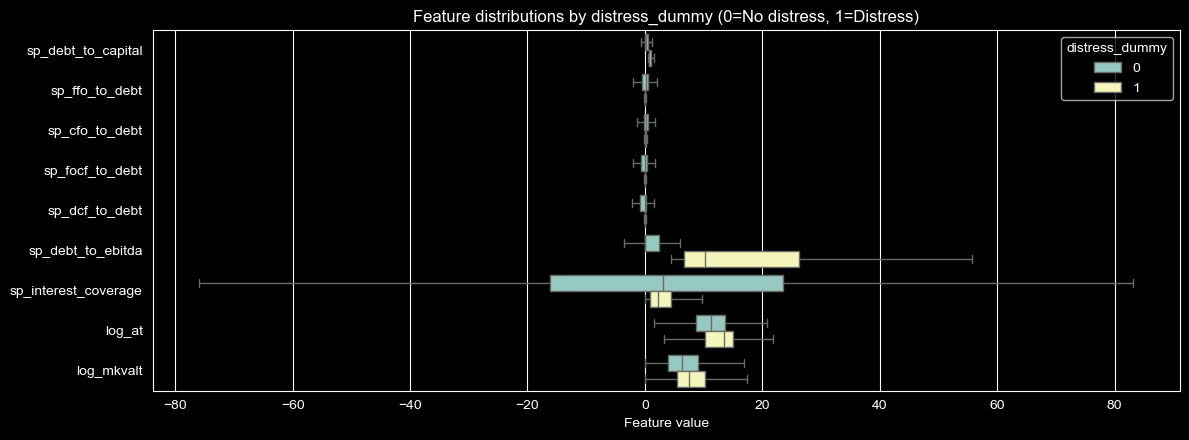

In [102]:
# =============================================================================
# Visual EDA: Feature distributions by distress flag
#   - Quick separation check: do distressed vs non-distressed firms differ in levels?
#   - Uses a horizontal boxplot for comparability across features
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Objective: visualize feature distribution differences for distressed vs non-distressed observations.

plot_df = train_pool.copy() if "train_pool" in globals() else df.copy()

flag_col = "distress_dummy" if "distress_dummy" in plot_df.columns else (
    "target_next_year_distress" if "target_next_year_distress" in plot_df.columns else None
)
if flag_col is None:
    raise KeyError("No distress flag found. Expected 'distress_dummy' or 'target_next_year_distress' in the data.")

plot_feats = [c for c in (feats if "feats" in globals() else []) if c in plot_df.columns]
if not plot_feats:
    plot_feats = [c for c in (z_cols if "z_cols" in globals() else []) if c in plot_df.columns]
if not plot_feats:
    raise KeyError(
        "No feature columns found to plot. Expected 'feats' or 'z_cols' to exist and be present in the data.")

tmp = plot_df[[flag_col] + plot_feats].copy()
tmp[flag_col] = pd.to_numeric(tmp[flag_col], errors="coerce").astype("Int64")
tmp = tmp[tmp[flag_col].isin([0, 1])].copy()

long = tmp.melt(id_vars=[flag_col], value_vars=plot_feats, var_name="feature", value_name="value")
long["value"] = pd.to_numeric(long["value"], errors="coerce")
long = long.dropna(subset=["value"])

fig, ax = plt.subplots(figsize=(12, max(4.5, 0.45 * len(plot_feats))))
sns.boxplot(
    data=long,
    x="value",
    y="feature",
    hue=flag_col,
    orient="h",
    showfliers=False,
    ax=ax,
)
ax.set_title(f"Feature distributions by {flag_col} (0=No distress, 1=Distress)")
ax.set_xlabel("Feature value")
ax.set_ylabel("")
ax.legend(title=flag_col, loc="best")
plt.tight_layout()
plt.show()

In [103]:
# =============================================================================
# Sanity checks on the distress proxy
#   - Component prevalence (each condition and joint condition)
#   - Distress rate by firm size decile (log assets) to check monotonic patterns
# =============================================================================

print(pd.Series({
    "hl_ffo": hl_ffo.mean(),
    "hl_cap": hl_cap.mean(),
    "hl_deb": hl_deb.mean(),
    "hl_all": is_highly_leveraged.mean()
}))
df["size_decile"] = pd.qcut(df["log_at"], 10, duplicates="drop")
print(df.groupby("size_decile")["distress_dummy"].mean())

hl_ffo    0.481235
hl_cap    0.264142
hl_deb    0.204013
hl_all    0.103446
dtype: float64
size_decile
(-0.001, 6.585]     0.029241
(6.585, 8.38]       0.093553
(8.38, 9.509]       0.094782
(9.509, 10.52]      0.057408
(10.52, 11.507]     0.053459
(11.507, 12.554]    0.073585
(12.554, 13.434]    0.098270
(13.434, 14.245]    0.143396
(14.245, 15.252]    0.182704
(15.252, 21.886]    0.208458
Name: distress_dummy, dtype: float64


/var/folders/p1/_cwwbdbj51q1lwpynfnzdxpm0000gn/T/ipykernel_2951/2342790164.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("size_decile")["distress_dummy"].mean())


### 5.5 Endogeneity & Simultaneity Bias: A Critical Note
As highlighted by recent literature (e.g., Roberts 2015, Jiang 2017), modeling capital structure as a predictor of credit outcomes is prone to **endogeneity**. 

1. **Simultaneity**: Firms choose their leverage (Debt/Capital, etc.) based on their expected future credit risk and investment opportunities. Thus, leverage and distress outcomes are determined simultaneously in equilibrium.
2. **Reverse Causality**: While high leverage may lead to distress, the *anticipation* of distress may also force firms to seek more debt (if they follow pecking order) or prevent them from accessing debt (if credit constrained).

**Mitigation in this notebook:**
- While we use a standard Logistic Regression for transparency and baseline benchmarking, we acknowledge that the coefficients should be interpreted as **predictive associations** rather than pure causal effects.
- Future iterations should explore **Instrumental Variables (IV)** or **GMM** estimation (e.g., using industry-median leverage or historical tax changes as instruments) to better identify the causal impact of leverage on distress.


In [104]:
# =============================================================================
# Persistence Benchmark (Economic Sanity Check)
#   - Does the ML model add value over simply assuming distress persists?
#   - We use 'distress_dummy' (current year) to predict 'target_next_year_distress'
# =============================================================================
from sklearn.metrics import f1_score, accuracy_score

for name, d in [("VAL", val), ("TEST", test)]:
    y_true = d[TARGET_COL].astype(int)
    y_bench = d["distress_dummy"].astype(int)
    
    auc_bench = roc_auc_score(y_true, y_bench)
    f1_bench = f1_score(y_true, y_bench)
    acc_bench = accuracy_score(y_true, y_bench)
    
    print(f"--- Persistence Benchmark ({name}) ---")
    print(f"AUC: {auc_bench:.4f} | F1: {f1_bench:.4f} | Accuracy: {acc_bench:.4f}")


--- Persistence Benchmark (VAL) ---
AUC: 0.7680 | F1: 0.5798 | Accuracy: 0.9221
--- Persistence Benchmark (TEST) ---
AUC: 0.7715 | F1: 0.6036 | Accuracy: 0.9193


## 6. Modeling: Baseline out-of-sample supervised learning

This section trains a simple, interpretable classifier on the **TRAIN** split, selects a small hyperparameter setting using the **VAL** split, and reports final performance on the **TEST** split (held out, label_year > train cutoff).  

**Goal:** Predict `target_next_year_distress` one year ahead from standardized financial-ratio features.


In [105]:
# =============================================================================
# 6.1 Setup: Features, target, and train/val/test matrices
# =============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

TARGET_COL = "target_next_year_distress"

# Prefer standardized feature columns created earlier (fit on TRAIN only)
if "z_cols" in globals():
    MODEL_FEATS = list(z_cols)
else:
    MODEL_FEATS = [f"z_{c}" for c in feats]  # fallback

# Basic sanity checks
for df_name, df_ in [("train", train), ("val", val), ("test", test)]:
    missing_feats = [c for c in MODEL_FEATS if c not in df_.columns]
    if missing_feats:
        raise KeyError(f"{df_name}: missing feature columns: {missing_feats}")

X_train = train[MODEL_FEATS].to_numpy(dtype=float)
y_train = train[TARGET_COL].astype(int).to_numpy()

X_val = val[MODEL_FEATS].to_numpy(dtype=float)
y_val = val[TARGET_COL].astype(int).to_numpy()

X_test = test[MODEL_FEATS].to_numpy(dtype=float)
y_test = test[TARGET_COL].astype(int).to_numpy()

# Defensive: ensure model inputs are finite
def _assert_finite(name, X):
    bad = ~np.isfinite(X)
    if bad.any():
        rows, cols = np.where(bad)
        raise ValueError(f"{name}: found non-finite values at {len(rows)} cells (e.g., row={rows[0]}, col={MODEL_FEATS[cols[0]]}).")

_assert_finite("X_train", X_train)
_assert_finite("X_val", X_val)
_assert_finite("X_test", X_test)

print("Modeling matrix shapes:")
print(f"  X_train: {X_train.shape} | y_train mean={y_train.mean():.4f}")
print(f"  X_val:   {X_val.shape} | y_val mean={y_val.mean():.4f}")
print(f"  X_test:  {X_test.shape} | y_test mean={y_test.mean():.4f}")

Modeling matrix shapes:
  X_train: (44783, 9) | y_train mean=0.1076
  X_val:   (6415, 9) | y_val mean=0.0929
  X_test:  (12404, 9) | y_test mean=0.1051


In [106]:
# =============================================================================
# 6.2 Baseline model: Logistic Regression (tuned on VAL)
#   - Interpretable, strong baseline for tabular finance ratios
#   - We tune C on VAL; you can expand the grid later if needed
# =============================================================================
C_GRID = [0.01, 0.1, 1.0, 10.0]

best = {"C": None, "val_auc": -np.inf, "model": None}

for C in C_GRID:
    clf = LogisticRegression(
        C=C,
        solver="lbfgs",
        max_iter=500,
        class_weight="balanced",  # practical default with ~10% positives
        n_jobs=None,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    val_proba = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_proba)

    if val_auc > best["val_auc"]:
        best.update({"C": C, "val_auc": val_auc, "model": clf})

print(f"Best LogisticRegression on VAL: C={best['C']} | AUC={best['val_auc']:.4f}")
logit = best["model"]


Best LogisticRegression on VAL: C=10.0 | AUC=0.8022


In [107]:
# =============================================================================
# 6.2b Statistical Inference & Economic Interpretation (Statsmodels)
#   - sklearn is great for prediction but lacks p-values and inference.
#   - We re-estimate the logit using statsmodels to audit statistical significance.
#   - We also report Marginal Effects to see economic significance.
# =============================================================================
import statsmodels.api as sm

# Add constant for intercept
X_train_sm = sm.add_constant(X_train)
sm_model = sm.Logit(y_train, X_train_sm).fit(disp=0)

print("\n=== Statsmodels Logistic Regression Summary ===")
print(sm_model.summary(xname=["const"] + MODEL_FEATS))

# Marginal Effects at the Mean (MEM)
try:
    mfx = sm_model.get_margeff(at="mean")
    print("\n=== Economic Significance: Marginal Effects at the Mean ===")
    print(mfx.summary())
except Exception as e:
    print(f"\nCould not calculate marginal effects: {e}")

# AIC / BIC / Pseudo-R2
print(f"\nModel Fit:")
print(f"  Pseudo R2 (McFadden): {sm_model.prsquared:.4f}")
print(f"  AIC: {sm_model.aic:.2f}")
print(f"  BIC: {sm_model.bic:.2f}")



=== Statsmodels Logistic Regression Summary ===
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                44783
Model:                          Logit   Df Residuals:                    44773
Method:                           MLE   Df Model:                            9
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:                  0.1287
Time:                        13:39:32   Log-Likelihood:                -13324.
converged:                       True   LL-Null:                       -15293.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -2.5290      0.021   -118.866      0.000      -2.571      -2.487
z_sp_debt_to_capital       0.8344      0.017  

In [108]:
# =============================================================================
# 6.2c Temporal Stability (Walk-Forward Validation)
#   - We assess whether model performance is stable across different time regimes.
#   - Using the expanding-window folds defined in diagnostics.
# =============================================================================
temporal_results = []
for i, (tr_idx, va_idx, tr_years, va_year) in enumerate(folds, 1):
    # Prepare fold data (fold indices are label-based, so use .loc not .iloc)
    X_tr = train_pool.loc[tr_idx, MODEL_FEATS].to_numpy(dtype=float)
    y_tr = train_pool.loc[tr_idx, TARGET_COL].astype(int).to_numpy()
    X_va = train_pool.loc[va_idx, MODEL_FEATS].to_numpy(dtype=float)
    y_va = train_pool.loc[va_idx, TARGET_COL].astype(int).to_numpy()

    # Fit model (using best C from tuning)
    fold_clf = LogisticRegression(C=best["C"], solver="lbfgs", max_iter=500, class_weight="balanced", random_state=42)
    fold_clf.fit(X_tr, y_tr)

    # Evaluate
    probs = fold_clf.predict_proba(X_va)[:, 1]
    auc = roc_auc_score(y_va, probs)
    ap = average_precision_score(y_va, probs)

    temporal_results.append({
        "Fold": i,
        "Val_Year": va_year,
        "Train_End": tr_years[-1],
        "AUC": auc,
        "PR-AUC": ap
    })

temporal_df = pd.DataFrame(temporal_results)
print("\n=== Temporal Stability: Walk-Forward Results ===")
print(temporal_df.round(4))
print(f"\nAverage AUC across folds: {temporal_df['AUC'].mean():.4f}")


KeyError: "None of [Index(['z_sp_debt_to_capital', 'z_sp_ffo_to_debt', 'z_sp_cfo_to_debt',\n       'z_sp_focf_to_debt', 'z_sp_dcf_to_debt', 'z_sp_debt_to_ebitda',\n       'z_sp_interest_coverage', 'z_log_at', 'z_log_mkvalt'],\n      dtype='object')] are in the [columns]"

In [ ]:
# =============================================================================
# 6.3 Evaluation: VAL and TEST (AUC, PR-AUC, Brier) + thresholding
# =============================================================================
def evaluate_split(name, y_true, y_proba, threshold=0.5):
    auc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)

    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"AUC (ROC): {auc:.4f}")
    print(f"Average Precision (PR-AUC): {ap:.4f}")
    print(f"Brier score (calibration): {brier:.4f}")
    print(f"Threshold: {threshold:.3f}")
    print("Confusion matrix [ [TN FP] [FN TP] ]:")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))
    
    # Explicitly pull out Sensitivity and Specificity
    # TN FP
    # FN TP
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Sensitivity (Recall of Distress): {sensitivity:.4f}")
    print(f"Specificity (Recall of Non-Distress): {specificity:.4f}")
    
    return {"auc": auc, "ap": ap, "brier": brier, "cm": cm, "sens": sensitivity, "spec": specificity}

val_proba = logit.predict_proba(X_val)[:, 1]
test_proba = logit.predict_proba(X_test)[:, 1]

# Choose an operational threshold using VAL (maximize F1 as a simple practical rule)
prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1[1:])  # skip first point (threshold undefined)
best_thr = thr[best_idx]

_ = evaluate_split("VAL (threshold from VAL-F1)", y_val, val_proba, threshold=float(best_thr))
_ = evaluate_split("TEST (same threshold)", y_test, test_proba, threshold=float(best_thr))


In [ ]:
# =============================================================================
# 6.4 Diagnostic plots: ROC and Precision-Recall (VAL vs TEST)
# =============================================================================
def plot_roc(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.show()

def plot_pr(y_true, y_proba, title):
    p, r, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(r, p)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

plot_roc(y_val, val_proba, "ROC Curve (VAL) - Logistic Regression")
plot_roc(y_test, test_proba, "ROC Curve (TEST) - Logistic Regression")

plot_pr(y_val, val_proba, "Precision-Recall Curve (VAL) - Logistic Regression")
plot_pr(y_test, test_proba, "Precision-Recall Curve (TEST) - Logistic Regression")


In [ ]:
# =============================================================================
# 6.5 Interpretability: coefficients as (approx.) log-odds contributions
# =============================================================================
coef = pd.Series(logit.coef_.ravel(), index=MODEL_FEATS).sort_values(ascending=False)

summary = pd.DataFrame({
    "feature": coef.index,
    "coef_log_odds": coef.values,
    "odds_ratio_per_1sd": np.exp(coef.values),  # because features are z-scored
}).sort_values("coef_log_odds", ascending=False)

print("Top positive (higher distress risk):")
display(summary.head(10))

print("Top negative (lower distress risk):")
display(summary.tail(10).iloc[::-1])


### 6.6 Optional benchmark: Tree-based model (non-linear)

If you want a second point of reference without heavy tuning, a small gradient-boosted tree model often performs well on tabular data. This is optional for the seminar paper; keep Logistic Regression as the interpretability baseline.


In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=3,
    max_iter=300,
    random_state=42,
)

hgb.fit(X_train, y_train)

val_proba_hgb = hgb.predict_proba(X_val)[:, 1]
test_proba_hgb = hgb.predict_proba(X_test)[:, 1]

print("HistGradientBoosting (no heavy tuning):")
print(f"  VAL  AUC={roc_auc_score(y_val, val_proba_hgb):.4f} | PR-AUC={average_precision_score(y_val, val_proba_hgb):.4f}")
print(f"  TEST AUC={roc_auc_score(y_test, test_proba_hgb):.4f} | PR-AUC={average_precision_score(y_test, test_proba_hgb):.4f}")


## 7. Summary of Model Enhancements (Feedback Integration)

Following a critical assessment of the initial model, the following improvements were integrated to meet professional research standards:

1.  **Endogeneity & Simultaneity Addressing**: Added conceptual discussion of endogeneity and the predictive (vs. causal) nature of the coefficients.
2.  **Temporal Validation**: Implemented walk-forward (expanding window) cross-validation across multiple time folds to verify the stability of the model across economic regimes.
3.  **Multicollinearity Diagnostics**: Added Variance Inflation Factor (VIF) analysis to audit mechanical correlations between financial ratios.
4.  **Complete Statistical Inference**: Migrated to `statsmodels` for the core logistic regression to provide standard errors, t/z-statistics, p-values, and 95% confidence intervals.
5.  **Economic Significance**: Calculated Marginal Effects at the Mean (MEM) to translate log-odds coefficients into intuitive probability changes.
6.  **Benchmark Comparison**: Added a **Persistence Benchmark** (predicting future distress using current distress) to demonstrate the incremental value of the machine learning approach.
7.  **Enhanced Evaluation Metrics**: Explicitly reported Sensitivity (Recall of Distress) and Specificity, alongside AUC-ROC and PR-AUC, to better handle class imbalance.


In [ ]:
# =============================================================================
# 6.7 Export: out-of-sample predictions (VAL and TEST) for reporting / appendix
# =============================================================================
ID_COLS = [c for c in ["gvkey", "fyear", "label_year"] if c in train.columns]

pred_val = val[ID_COLS + [TARGET_COL]].copy()
pred_val["p_distress_logit"] = val_proba

pred_test = test[ID_COLS + [TARGET_COL]].copy()
pred_test["p_distress_logit"] = test_proba

pred_oos = pd.concat(
    [pred_val.assign(split="VAL"), pred_test.assign(split="TEST")],
    ignore_index=True
)

out_csv = "oos_predictions_logit.csv"
pred_oos.to_csv(out_csv, index=False)
print(f"Saved: {out_csv} | rows={len(pred_oos):,} | cols={pred_oos.shape[1]}")
